In [ ]:
# | hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
# | default_exp inspect.classifier

# Classifier

> Inspector functionality specific to classification models

In [ ]:
# | export
from typing import Callable, Optional, Sequence, Union

import numpy as np
import pandas as pd
import sklearn

from model_inspector.delegate import delegates
from model_inspector.inspect.any_model import _Inspector
from model_inspector.tune import (
    calculate_metrics_by_thresh_binary,
    calculate_metrics_by_thresh_multi,
    confusion_matrix,
)

In [ ]:
# | export
class _ClasInspector(_Inspector):
    """Abstract class for classification model inspectors"""

    def calculate_metrics_by_thresh(*args, **kwargs):
        raise NotImplementedError()

    def confusion_matrix(*args, **kwargs):
        raise NotImplementedError()

## Binary Classification

In [ ]:
# | export
class _BinInspector(_ClasInspector):
    """Binary classification model inspector"""

    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        Parameters:

        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses `0` and the values that appear in `y_prob[:, 1]`, which
        is a minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: `DataFrame` with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_binary(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
            thresholds=thresholds,
        )

    @delegates(sklearn.metrics.confusion_matrix)
    def confusion_matrix(
        self,
        thresh: float = 0.5,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values,
        `self.model.predict_proba(self.X)[:, 1] > thresh` as
        predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.

        Parameters:

        - `thresh`: Probability threshold for counting a prediction as
        positive
        """
        labels = np.unique(self.y)
        return confusion_matrix(
            y_true=self.y,
            y_pred=np.where(
                self.model.predict_proba(self.X)[:, 1] > thresh, labels[1], labels[0]
            ),
            **kwargs,
        )

In [ ]:
# | hide
import warnings

In [ ]:
import sklearn.datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from model_inspector import get_inspector

In [ ]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
inspector = get_inspector(
    RandomForestClassifier().fit(X_train, y_train),
    X_test,
    y_test,
)

In [ ]:
# | hide
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# | hide
CLASSIFIERS = [
    MLPClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    KNeighborsClassifier,
    LogisticRegression,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    SVC,
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_class in CLASSIFIERS:
        model = model_class().fit(X, y)
        for method in ["calculate_metrics_by_thresh", "confusion_matrix"]:
            assert hasattr(get_inspector(model, X, y), method)

In [ ]:
# | hide
from model_inspector.inspect.classifier import _BinInspector  # noqa: F811

In [ ]:
# | hide
assert isinstance(inspector, _BinInspector)

In [ ]:
# | hide
from nbdev.showdoc import show_doc

In [ ]:
show_doc(_BinInspector.calculate_metrics_by_thresh)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/classifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### _BinInspector.calculate_metrics_by_thresh

>      _BinInspector.calculate_metrics_by_thresh
>                                                 (metrics:Union[Callable,Sequen
>                                                 ce[Callable]], thresholds:Opti
>                                                 onal[Sequence]=None)

Calculate classification metrics as a function of threshold

Assumes that `self.model` has a `.predict_proba()` method. Uses
`self.y` as ground-truth values,
`self.model.predict_proba(self.X)[:, 1] > thresh` as
predictions.

Parameters:

- `metrics`: Callables that take `y_true`, `y_pred` as
positional arguments and return a number. Must have a `__name__`
attribute.
- `thresholds`: `Sequence` of `float` threshold values to use. By
default uses `0` and the values that appear in `y_prob[:, 1]`, which
is a minimal set that covers all of the relevant possibilities. One
reason to override that default would be to save time with a large
dataset.

Returns: `DataFrame` with one column "thresh" indicating the
thresholds used and an additional column for each input metric
giving the value of that metric at that threshold.

In [ ]:
metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score],
).iloc[
    :-1
]  # dropping last row where precision is undefined
with pd.option_context("display.max_rows", 10):
    display(metrics_by_thresh)  # noqa: F821

  0%|                                                                                                  | 0/41 [00:00<?, ?it/s]/Users/greg.gandenberger/.pyenv/versions/3.11.2/envs/model_inspector311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 732.08it/s]


,thresh,precision_score,recall_score,f1_score
0,0.00,0.796748,1.000000,0.886878
1,0.00,0.796748,1.000000,0.886878
2,0.01,0.830508,1.000000,0.907407
3,0.02,0.844828,1.000000,0.915888
4,0.03,0.852174,1.000000,0.920188
...,...,...,...,...
35,0.95,0.961538,0.765306,0.852273
36,0.96,0.960526,0.744898,0.839080
37,0.97,0.972603,0.724490,0.830409
38,0.98,0.984127,0.632653,0.770186


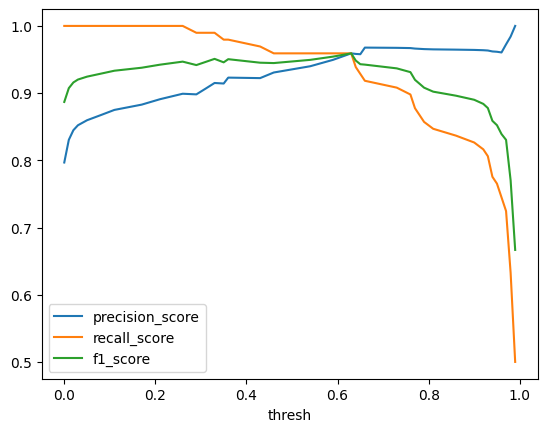

In [ ]:
ax = metrics_by_thresh.plot(x="thresh")

In [ ]:
# | hide
assert (
    len(
        inspector.calculate_metrics_by_thresh(
            metrics=[metrics.precision_score], thresholds=[0.1, 0.3, 0.5, 0.7, 0.9]
        )
    )
    == 5
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 883.20it/s]


In [ ]:
show_doc(_BinInspector.confusion_matrix)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/classifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### _BinInspector.confusion_matrix

>      _BinInspector.confusion_matrix (thresh:float=0.5, labels=None,
>                                      sample_weight=None, normalize=None)

Get confusion matrix

Assumes that `self.model` has a `.predict_proba()` method. Uses
`self.y` as ground-truth values,
`self.model.predict_proba(self.X)[:, 1] > thresh` as
predictions.

If output is not rendering properly when you reopen a notebook,
make sure the notebook is trusted.

Parameters:

- `thresh`: Probability threshold for counting a prediction as
positive

Remaining parameters are passed to `sklearn.metrics._classification.confusion_matrix`.

In [ ]:
inspector.confusion_matrix(
    thresh=metrics_by_thresh.loc[metrics_by_thresh.f1_score.idxmax(), "thresh"]
)

,Predicted 0,Predicted 1,Totals
Actual 0,41,4,45
Actual 1,4,94,98
Totals,45,98,143


## Multiclass Classification

In [ ]:
from functools import partial

from model_inspector.tune import calculate_metric_ignoring_nan, coverage

In [ ]:
precision_ignoring_nan = partial(
    calculate_metric_ignoring_nan,
    metric=partial(metrics.precision_score, average="micro"),
)
precision_ignoring_nan.__name__ = "precision_ignoring_nan"

X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
inspector = get_inspector(
    RandomForestClassifier().fit(X_train.iloc[:, [3]], y_train),
    X_test.iloc[:, [3]],
    y_test,
)

In [ ]:
# | export
class _MultiInspector(_ClasInspector):
    """Multiclass model inspector"""

    def calculate_metrics_by_thresh(
        self,
        metrics: Union[Callable, Sequence[Callable]],
        thresholds: Optional[Sequence] = None,
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Assumes that `self.model` has a `.predict_proba()` method. Uses
        `self.y` as ground-truth values, uses the value with the highest
        probability as the prediction if that probability exceeds the
        threshold, `np.nan` otherwise.

        Parameters:

        - `metrics`: Callables that take `y_true`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute and must be able to handle `np.nan` values.
        - `thresholds`: `Sequence` of `float` threshold values to use. By
        default uses 0 and all values that appear in `y_prob`, which is a
        minimal set that covers all of the relevant possibilities. One
        reason to override that default would be to save time with a large
        dataset.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used and an additional column for each input metric
        giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh_multi(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            metrics=metrics,
        )

    @delegates(pd.DataFrame().style.background_gradient)
    def confusion_matrix(
        self,
        **kwargs,
    ) -> pd.DataFrame:
        """Get confusion matrix

        Uses `self.y` as ground-truth values,
        `self.model.predict(self.X)` as predictions.

        If output is not rendering properly when you reopen a notebook,
        make sure the notebook is trusted.
        """

        return confusion_matrix(
            y_true=self.y,
            y_pred=self.model.predict(self.X),
            **kwargs,
        )

In [ ]:
show_doc(_MultiInspector.calculate_metrics_by_thresh)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/classifier.py#L103){target="_blank" style="float:right; font-size:smaller"}

### _MultiInspector.calculate_metrics_by_thresh

>      _MultiInspector.calculate_metrics_by_thresh
>                                                   (metrics:Union[Callable,Sequ
>                                                   ence[Callable]], thresholds:
>                                                   Optional[Sequence]=None)

Calculate classification metrics as a function of threshold

Assumes that `self.model` has a `.predict_proba()` method. Uses
`self.y` as ground-truth values, uses the value with the highest
probability as the prediction if that probability exceeds the
threshold, `np.nan` otherwise.

Parameters:

- `metrics`: Callables that take `y_true`, `y_pred` as
positional arguments and return a number. Must have a `__name__`
attribute and must be able to handle `np.nan` values.
- `thresholds`: `Sequence` of `float` threshold values to use. By
default uses 0 and all values that appear in `y_prob`, which is a
minimal set that covers all of the relevant possibilities. One
reason to override that default would be to save time with a large
dataset.

Returns: DataFrame with one column "thresh" indicating the
thresholds used and an additional column for each input metric
giving the value of that metric at that threshold.

In [ ]:
# | hide
from model_inspector.inspect.classifier import _MultiInspector

In [ ]:
# | hide
assert isinstance(inspector, _MultiInspector)

In [ ]:
metrics_by_thresh = inspector.calculate_metrics_by_thresh(
    metrics=[coverage, precision_ignoring_nan],
).iloc[
    :-1
]  # dropping last row where precision is undefined
metrics_by_thresh

  0%|                                                                                                  | 0/13 [00:00<?, ?it/s]/Users/greg.gandenberger/.pyenv/versions/3.11.2/envs/model_inspector311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1667.92it/s]


,thresh,coverage,precision_ignoring_nan
0,0.000000,1.000000,0.947368
1,0.000000,1.000000,0.947368
2,0.017493,1.000000,0.947368
3,0.046875,1.000000,0.947368
4,0.122164,1.000000,0.947368
5,0.139610,1.000000,0.947368
6,0.206660,1.000000,0.947368
7,0.793340,0.947368,0.944444
8,0.860390,0.921053,0.942857
9,0.877836,0.815789,0.935484


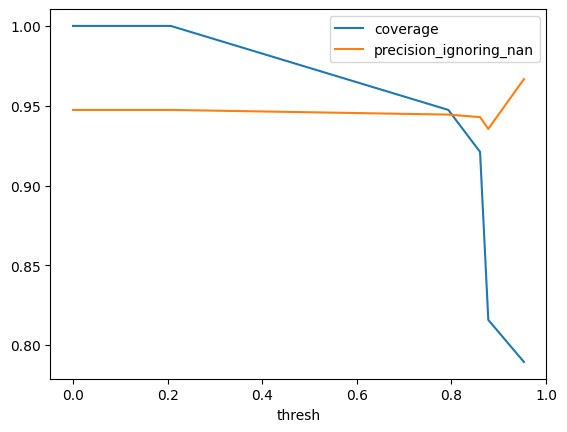

In [ ]:
ax = metrics_by_thresh.iloc[:-1].plot(x="thresh")

In [ ]:
# | hide
assert len(
    inspector.calculate_metrics_by_thresh(
        metrics=[coverage, precision_ignoring_nan],
        thresholds=[0, 0.25, 0.5, 0.75, 0.99],
    )
    == 5
)

  0%|                                                                                                  | 0/13 [00:00<?, ?it/s]/Users/greg.gandenberger/.pyenv/versions/3.11.2/envs/model_inspector311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1550.75it/s]


In [ ]:
show_doc(_MultiInspector.confusion_matrix)

---

[source](https://github.com/gsganden/model_inspector/tree/main/blob/main/model_inspector/inspect/classifier.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### _MultiInspector.confusion_matrix

>      _MultiInspector.confusion_matrix (cmap='PuBu', low:float=0, high:float=0,
>                                        axis:Axis|None=0,
>                                        subset:Subset|None=None,
>                                        text_color_threshold:float=0.408,
>                                        vmin:float|None=None,
>                                        vmax:float|None=None,
>                                        gmap:Sequence|None=None)

Get confusion matrix

Uses `self.y` as ground-truth values,
`self.model.predict(self.X)` as predictions.

If output is not rendering properly when you reopen a notebook,
make sure the notebook is trusted.

Remaining parameters are passed to `pandas.io.formats.style.background_gradient`.

In [ ]:
inspector.confusion_matrix()

,Predicted 0,Predicted 1,Predicted 2,Totals
Actual 0,16,0,0,16
Actual 1,0,10,1,11
Actual 2,0,1,10,11
Totals,16,11,11,38


In [ ]:
# | export
_all_ = ["_BinInspector", "_MultiInspector"]